## Project Setup

In [18]:
# Import Standard Modules
import numpy as np
import pandas as pd 

# Plotting Modules
import matplotlib.pyplot as plt
import seaborn as sns

# To handle text
import re
import string

# Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model building
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Tuning
import keras_tuner as kt

# Measurement 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Project Topic

This is a Kaggle project that is intended for using Natural Language Processing  to build a model that predicts if a tweet is about a real disaster or just a figure of speech.

## Data Load and Prep

In [3]:
# Load the train and test set
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

## EDA

In [6]:
# Take a look at the train data
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Take a look at test set
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# Describe the train set
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [8]:
# Describe the test set
df_test.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


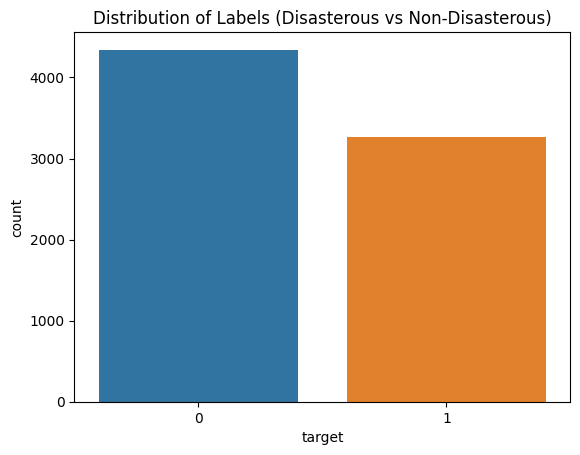

In [9]:
# Look at distribution of class
sns.countplot(x='target', data=df_train)
plt.title("Distribution of Labels (Disasterous vs Non-Disasterous)")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


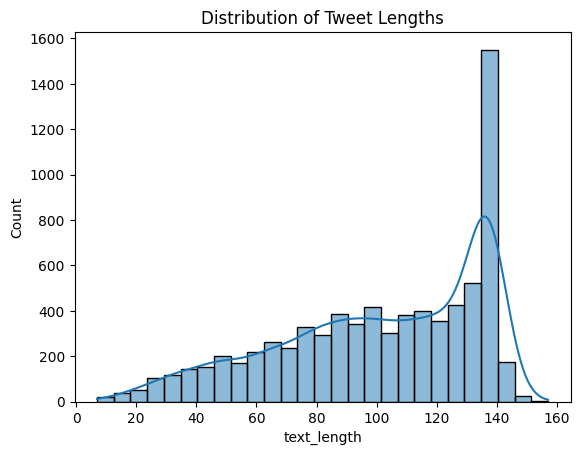

In [12]:
# Distribution of tweet lengths
df_train['text_length'] = df_train['text'].apply(len)
sns.histplot(df_train['text_length'], kde=True)
plt.title("Distribution of Tweet Lengths")
plt.show()

The data is clean and has a fairly even class distribution. Many of the tweets are at the 140 character limit.

## Data Cleaning

In [33]:
# Clean the text, 
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.lower()  # Lowercase
    return text

df_train['cleaned_text'] = df_train['text'].apply(clean_text)
df_test['cleaned_text'] = df_test['text'].apply(clean_text)

## Tokenization

In [43]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df_train['cleaned_text'])
padded_sequences = pad_sequences(sequences, padding='post', maxlen=50)

sequences_test = tokenizer.texts_to_sequences(df_test['cleaned_text'])
padded_sequences_test = pad_sequences(sequences_test, padding='post', maxlen=50)

Tokenization is convertin text into a sequence of tokens that a model can understand. For example, take the text "The Flatirons are fun to go hiking in." 
* split the sentence into each word or token
* cleaned by removing punctuation and case sensitivity
* assign each word a unique integer
* padding each string with 0s to reach the maximum length


This process matters so that the machine learning model can input the data through a numerican index and handle varying text lengths.


* https://keras.io/api/keras_nlp/tokenizers/tokenizer/
* https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer


## Model Build

In [19]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=50),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, df_train['target'], test_size=0.2)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.5633 - loss: 0.6875 - val_accuracy: 0.5752 - val_loss: 0.6818
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.5910 - loss: 0.6668 - val_accuracy: 0.7387 - val_loss: 0.5660
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.7254 - loss: 0.5797 - val_accuracy: 0.7393 - val_loss: 0.5636
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.7340 - loss: 0.5729 - val_accuracy: 0.7400 - val_loss: 0.5619
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.7443 - loss: 0.5579 - val_accuracy: 0.7380 - val_loss: 0.5630
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.7448 - loss: 0.5599 - val_accuracy: 0.7374 - val_loss: 0.5633
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.7471 - loss: 0.5511 - val_accuracy: 0.7380 - val_loss: 0.5620
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.7582 - loss: 0.5378 - val_

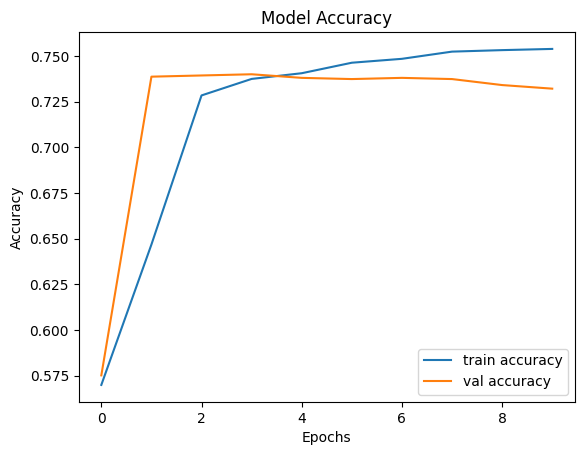

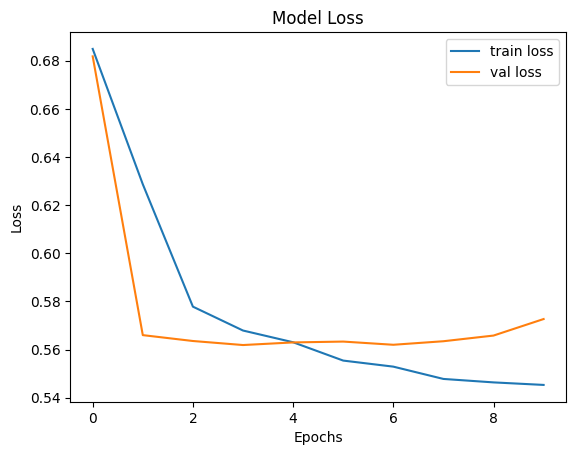

In [24]:
# Plotting accuracy and loss curves
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [25]:
# Predict on the validation set
y_pred = (model.predict(X_val) > 0.5).astype("int32")

# Accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_val, y_pred)
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_val, y_pred)
print(f"Recall: {recall}")

# F1 Score
f1 = f1_score(y_val, y_pred)
print(f"F1 Score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Accuracy: 0.7321076822061721
Precision: 0.6591211717709721
Recall: 0.7650695517774343
F1 Score: 0.7081545064377683
Confusion Matrix:
[[620 256]
 [152 495]]


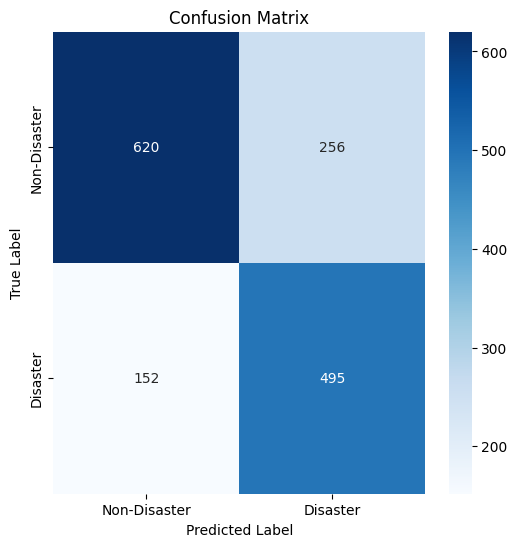

In [31]:
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Disaster', 'Disaster'], yticklabels=['Non-Disaster', 'Disaster'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Hyperparameter Tuning

In [27]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=hp.Choice('embedding_dim', [32, 64, 128]), input_length=50))
    model.add(Bidirectional(LSTM(hp.Int('lstm_units', min_value=32, max_value=128, step=32), return_sequences=True)))
    model.add(Dropout(hp.Choice('dropout_rate', [0.2, 0.3, 0.5])))
    model.add(LSTM(hp.Int('lstm_units_2', min_value=32, max_value=128, step=32)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='disaster_tweets_tuning'
)

tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=32)
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()


Trial 5 Complete [00h 02m 16s]
val_accuracy: 0.5751805901527405

Best val_accuracy So Far: 0.6454366445541382
Total elapsed time: 00h 07m 06s


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 757,569 (2.89 MB)

 Trainable params: 757,569 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

#### See how best model performs

In [28]:
# Predict on the validation set
y_pred_tuned = (best_model.predict(X_val) > 0.5).astype("int32")

# Accuracy
accuracy_tuned = accuracy_score(y_val, y_pred_tuned)
print(f"Accuracy: {accuracy_tuned}")

# Precision
precision_tuned = precision_score(y_val, y_pred_tuned)
print(f"Precision: {precision_tuned}")

# Recall
recall_tuned = recall_score(y_val, y_pred_tuned)
print(f"Recall: {recall_tuned}")

# F1 Score
f1_tuned = f1_score(y_val, y_pred_tuned)
print(f"F1 Score: {f1_tuned}")

# Confusion Matrix
conf_matrix_tuned = confusion_matrix(y_val, y_pred_tuned)
print("Confusion Matrix:")
print(conf_matrix_tuned)


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Accuracy: 0.6454366382140512
Precision: 0.5566137566137566
Recall: 0.8129829984544049
F1 Score: 0.6608040201005025
Confusion Matrix:
[[457 419]
 [121 526]]


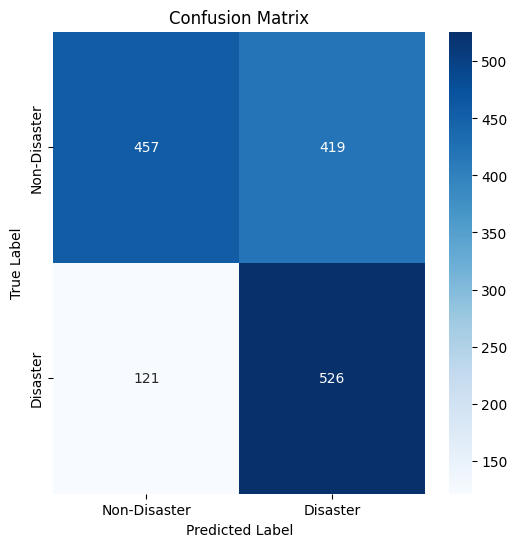

In [30]:
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Disaster', 'Disaster'], yticklabels=['Non-Disaster', 'Disaster'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Conclusions

The initial model architecture performs fairly well, achieving a 73% accuracy. With the hyperparamter tuning, the accuracy drops to 65%, but recall jumps from 77% to 83%. 

This is important as with something as important as disaster is it may be more important to capture all possible disasters rather than optimizing to precision. 

Some additional enhancements I could make are the following:
* using more robust tokenization to capture part of words which may help with misspellings
* use contextualized embeddings
* use ensemble models to combine predictions from several models such as LSTM and CNN
* use cross-fold validation isntead of a single split

## Submission

In [39]:
df_test.tail()

,id,keyword,location,text,cleaned_text
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety los angeles ûò safety faste...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,storm in ri worse than last hurricane my citya...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,green line derailment in chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issues hazardous weather outlook hwo
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,cityofcalgary has activated its municipal emer...


In [47]:
df_test['target'] = (model.predict(padded_sequences_test) > 0.5).astype("int32")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [48]:
submission = df_test[['id', 'target']]

In [52]:
submission.to_csv("submission.csv", index=False)